## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Oriyomi Raheem, Ali Eghbali, Michael Pyrcz, Carlos Torres-Verdin, 2024
***

In [1]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

Matplotlib created a temporary cache directory at /mnt/e/Anisotropic-Resistivity-Inversion/matplotlib-o1dhc71j because the default path (/home/misaelmorales/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.



------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.2.1+cu121 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------



### Case 1

In [ ]:
case1_qinv = ari.quadratic_inversion(case1)

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5,1.45], Rvsh=2.813, Rhsh=0.775, 
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv1, figsize=(20,12))

In [ ]:
inv1 = ari.resistivity_inversion(case1, x0=[0.5, 1.45], Rvsh=2.813, Rhsh=0.775,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5,
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv1, figsize=(20,12))

### Case 2

In [ ]:
case2_qinv = ari.quadratic_inversion(case2)

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674,
                                 Wd_matrix=True, tolerance=1e-10, maxiter=1e5, 
                                 lambda_reg=1e-8, method='CG', bounds=None)

ari.plot_inversion_results(inv2, figsize=(20,12))

In [ ]:
inv2 = ari.resistivity_inversion(case2, x0=[0.5,1.45], Rvsh=4.043, Rhsh=0.674, 
                                 Wd_matrix=True, tolerance=1e-8, maxiter=1e5, 
                                 lambda_reg=1e-8, method='L-BFGS-B', bounds=[(0,1),(None,None)])

ari.plot_inversion_results(inv2, figsize=(20,12))

***
# Physics-Informed Artificial Neural Network
***

In [ ]:
from main import *
ari = ARI()
case1, case2 = ari.load_data()

In [651]:
def plot_pinn_results(df, figsize=(15,10), subtitle:str=None):
    fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True)
    ax1, ax2, ax3, ax4 = axs

    ax11 = ax1.twiny()
    ari.plot_curve(ax1, df, 'GR', 0, 150, 'g', units='API', pad=8)
    ari.plot_curve(ax11, df, 'Csh_pred', 0, 1, 'k', units='v/v')

    ax21, ax22 = ax2.twiny(), ax2.twiny()
    ari.plot_curve(ax21, df, 'AT10', 0.02, 200, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax22, df, 'AT90', 0.02, 200, 'b', semilog=True, units='$\Omega\cdot m$', pad=16)
    ari.plot_curve(ax2, df, 'Rss_pred', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)

    ax31, ax32 = ax3.twiny(), ax3.twiny()
    ari.plot_curve(ax31, df, 'Rv', 0.02, 200, 'r', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax32, df, 'Rv_sim', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax3, df, 'Rv_err', 0, 100, 'darkred', alpha=0.5, units='%', pad=16)

    ax41, ax42 = ax4.twiny(), ax4.twiny()
    ari.plot_curve(ax41, df, 'Rh', 0.02, 200, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
    ari.plot_curve(ax42, df, 'Rh_sim', 0.02, 200, 'k', units='$\Omega\cdot m$', semilog=True)
    ari.plot_curve(ax4, df, 'Rh_err', 0, 100, 'darkblue', alpha=0.5, units='%', pad=16)

    [ax.grid(True, which='both') for ax in axs]
    ax1.invert_yaxis()
    if subtitle is None:
        title = 'PINN Inversion Results'
    else:
        title = 'PINN Inversion Results | {}'.format(subtitle)
    fig.suptitle(title, weight='bold')
    plt.tight_layout()
    plt.show()

In [642]:
class PINNari(nn.Module):
    def __init__(self):
        super(PINNari, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)
        return x

In [653]:
class PhysicsInformedLoss(torch.nn.Module):
    def __init__(self, Rvsh=2.8133, Rhsh=0.7746):
        super(PhysicsInformedLoss, self).__init__()
        self.Rvsh = Rvsh
        self.Rhsh = Rhsh

    def forward(self, inputs, outputs):
        Rv_true, Rh_true = inputs[:, 0], inputs[:, 1]
        Csh, Rss = outputs[:, 0], outputs[:, 1]

        eq1 = (Csh*self.Rvsh + (1-Csh)*Rss) - Rv_true
        eq2 = (Csh/self.Rhsh + (1-Csh)/Rss) - (1/Rh_true)
        eqs = torch.cat((eq1, eq2), dim=0)

        return torch.norm(eqs, p=2)

In [654]:
d = lasio.read('well1.las').df()[['AT10','AT30','AT60','AT90','GR','RV72H_1D_FLT','RH72H_1D_FLT']].dropna()
#d = lasio.read('well2.LAS').df()[['AT10','AT30','AT60','AT90','HCGR','RV72_1DF','RH72_1DF']].dropna()

column_names = ['AT10', 'AT30', 'AT60', 'AT90', 'GR', 'Rv', 'Rh']
data = d.rename(columns=dict(zip(d.columns, column_names)))

res_aniso  = data[['Rv','Rh']]
Rvsh, Rhsh = 2.8133, 0.7746

In [655]:
inputs     = torch.tensor(res_aniso.values, dtype=torch.float32)
dataset    = TensorDataset(inputs)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

model      = PINNari()
criterion  = PhysicsInformedLoss(Rvsh=Rvsh, Rhsh=Rhsh)
optimizer  = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1000
for epoch in range(epochs):
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch[0]
        y = model(x)
        loss = criterion(x, y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: {} | Loss: {:.4f}'.format(epoch, loss))

Epoch: 0 | Loss: 97.8352
Epoch: 100 | Loss: 24.3534
Epoch: 200 | Loss: 14.9205
Epoch: 300 | Loss: 14.8728
Epoch: 400 | Loss: 14.4503
Epoch: 500 | Loss: 12.7881
Epoch: 600 | Loss: 12.9494
Epoch: 700 | Loss: 14.1963
Epoch: 800 | Loss: 14.0258
Epoch: 900 | Loss: 12.8297


/mnt/e/Anisotropic-Resistivity-Inversion/main.py:102: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_xlim(lb, ub)


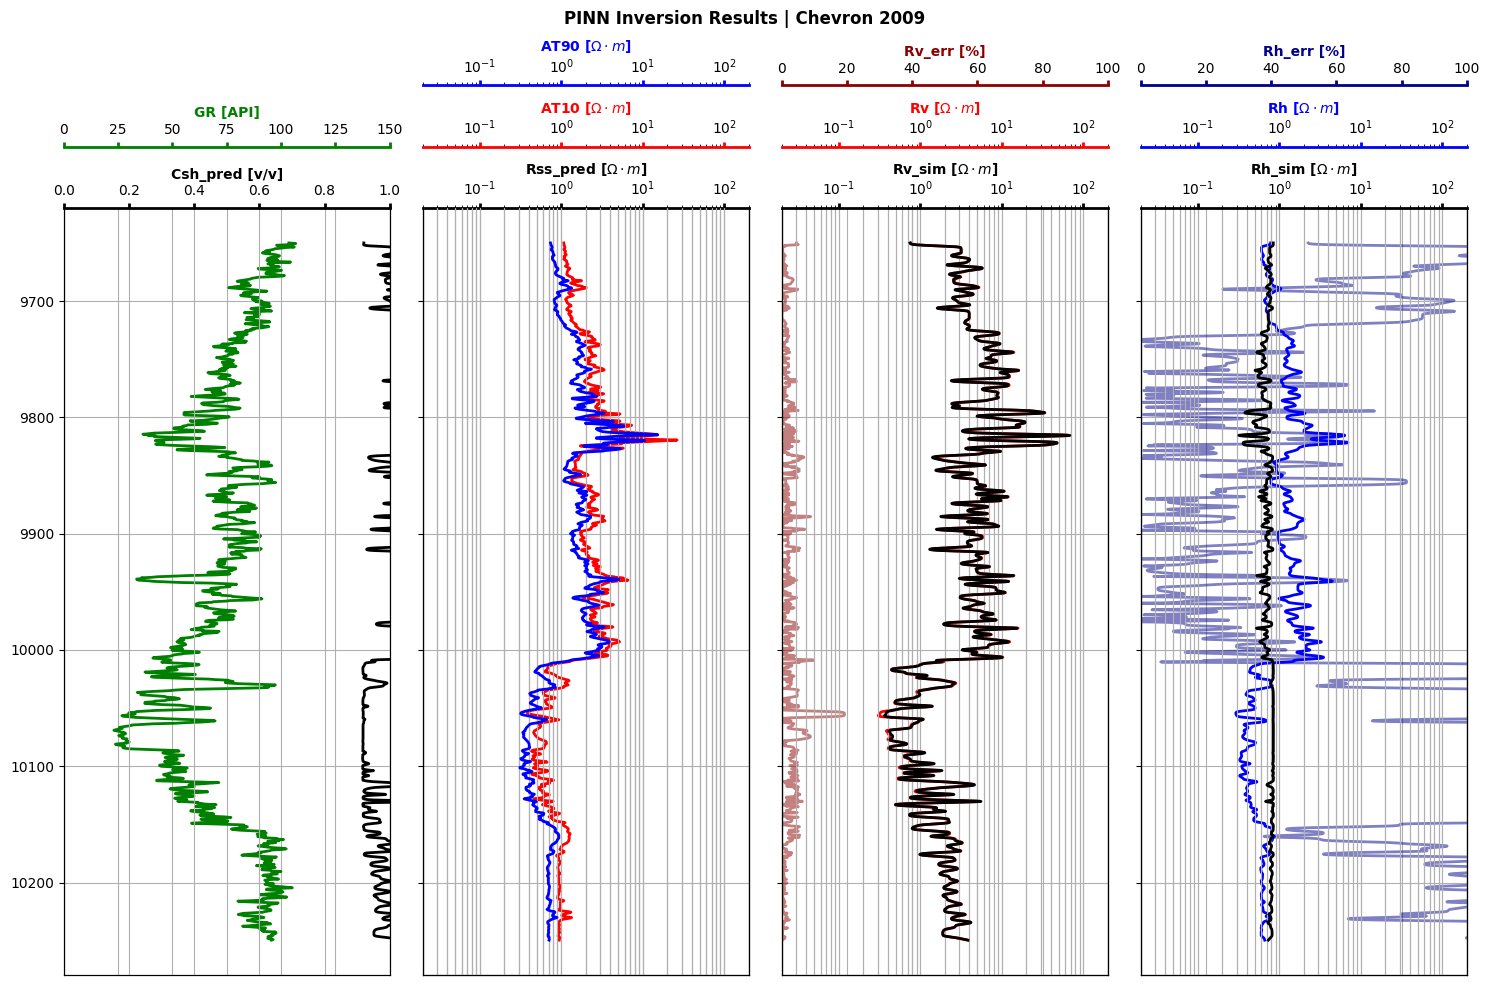

In [656]:
y = model(inputs).detach().numpy()
csh_pred, rss_pred = y[:,0], y[:,1]

Rv_sim = (csh_pred*Rvsh + (1-csh_pred)*rss_pred)
Rh_sim = (csh_pred/Rhsh + (1-csh_pred)/rss_pred)
Rv_err = np.abs((Rv_sim - case1['Rv'].values)/case1['Rv'].values) * 100
Rh_err = np.abs((Rh_sim - case1['Rh'].values)/case1['Rh'].values) * 100

sol = pd.DataFrame({'Csh_pred':csh_pred, 'Rss_pred':rss_pred,
                    'Rv_sim':Rv_sim, 'Rh_sim':1/Rh_sim,
                    'Rv_err':Rv_err, 'Rh_err':Rh_err}, index=case1.index)

results = pd.concat([case1, sol], axis=1)
plot_pinn_results(results, subtitle='Chevron 2009')

***
# END
***

In [ ]:
from scipy.io import loadmat

In [222]:
ali_cg = loadmat('sol.mat', simplify_cells=True)['sol']
ali_Csh = ali_cg[0,:]
ali_Rss = ali_cg[1,:]
print(ali_cg.shape)

ali = pd.read_csv('RVRH.csv', header=None)
ali.head()

,0,1,2,3,4,5,6,7,8,9,...,2409,2410,2411,2412,2413,2414,2415,2416,2417,2418
0,9648.50,0.7831,0.7839,0.903042,0.879753,0.783173,2.3347,NaN,0.000305,0.783173,...,0.777625,0.827270,0.864898,0.857611,0.897093,0.837377,0.901715,0.900800,0.900501,0.897194
1,9648.75,0.7827,0.7853,0.972779,0.946261,0.782936,2.3340,NaN,0.000990,0.782936,...,0.826216,0.999556,1.353591,3.043100,3.100034,3.293700,5.896764,7.379225,8.776103,9.727068
2,9649.00,0.7817,0.7887,0.960787,0.934825,0.782333,2.3332,NaN,0.002666,0.782333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9649.25,0.7794,0.7967,0.949343,0.923910,0.780950,2.3348,NaN,0.006593,0.780950,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9649.50,0.7746,0.8133,1.000000,0.976618,0.777992,2.3363,NaN,0.014761,0.777992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [412]:
lambda_reg = 1e-5

def objective(variables, *args):
    Csh, Rs = variables   
    Rv,  Rh = args[0], args[1]
    eq1 = (Csh*Rvsh + (1-Csh)*Rs) - Rv
    eq2 = (Csh/Rhsh + (1-Csh)/Rs) - (1/Rh)   
    eqs = [eq1/Rv, eq2*Rh]
    return linalg.norm(eqs,2) + lambda_reg*linalg.norm(variables,2)

def constraint(variables):
    Csh, Rss = variables
    Csh = np.clip(Csh, 0, 1)
    return Csh, Rss

In [612]:
case1['Rvsh_win'] = np.nan_to_num(np.array(pd.Series(case1['Rv']).rolling(250).max().tolist()), nan=case1['Rv'].mean())
case1['Rhsh_win'] = np.nan_to_num(np.array(pd.Series(case1['Rh']).rolling(250).max().tolist()), nan=case1['Rh'].mean())
R_min = np.min([case1['Rh'].min(), case1['Rv'].min()])
R_max = np.max([case1['Rh'].max(), case1['Rv'].max()])

res_aniso = case1[['Rv', 'Rh', 'CSH_lin', 'Rvsh_win', 'Rhsh_win']]

sol, fun, jac, nfev = [], [], [], []
for _, row in res_aniso.iterrows():
    Rv_value, Rh_value, Csh_lin = row['Rv'], row['Rh'], row['CSH_lin']
    Rvsh_max, Rhsh_max = row['Rvsh_win'], row['Rhsh_win']
    solution = optimize.minimize(objective,
                                 x0          = [Csh_lin, Rv_value],
                                 args        = (Rv_value, Rh_value, Rvsh_max, Rhsh_max),
                                 method      = 'L-BFGS-B',
                                 bounds      = [(0,1),(R_min,R_max)],
                                 tol         = 1e-6,
                                 options     = {'maxiter':1e3})
    fun.append(solution.fun)
    jac.append(solution.jac); nfev.append(solution.nfev)
    jac_arr = np.array(jac)
    jac1, jac2 = jac_arr[:,0], jac_arr[:,1]
    sol.append({'Rv':Rv_value, 'Rh':Rh_value, 'Csh_pred':solution.x[0], 'Rss_pred':solution.x[1]})
sol = pd.DataFrame(sol, index=res_aniso.index)
sol['fun'], sol['nfev'], sol['jac1'], sol['jac2'] = fun, nfev, jac1, jac2
sol['jac_norm'] = linalg.norm(jac, axis=1)

sol['Rv_sim'] = sol['Csh_pred']*Rvsh + (1-sol['Csh_pred'])*sol['Rss_pred']
sol['Rh_sim'] = 1/(sol['Csh_pred']/Rhsh + (1-sol['Csh_pred'])/sol['Rss_pred'])
sol.head()

,Rv,Rh,Csh_pred,Rss_pred,fun,nfev,jac1,jac2,jac_norm,Rv_sim,Rh_sim
DEPTH,,,,,,,,,,,
9650.00,0.7839,0.7831,0.000344,0.783183,0.000009,105,-1.801560,0.289448,1.824664,0.783900,0.783100
9650.25,0.7853,0.7827,0.001118,0.782967,0.000008,108,-0.155749,1.327335,1.336441,0.785300,0.782700
9650.50,0.7887,0.7817,0.003010,0.782416,0.000009,99,-2.575439,-0.705153,2.670230,0.788699,0.781700
9650.75,0.7967,0.7794,0.007443,0.781152,0.000009,105,-1.004008,0.873212,1.330613,0.796700,0.779401
9651.00,0.8133,0.7746,0.016668,0.778439,0.000009,99,2.427109,0.516949,2.481551,0.813301,0.774600


In [427]:
Rv_sim_ali = ali_Csh*Rvsh + (1-ali_Csh)*ali_Rss
Rh_sim_ali = 1/(ali_Csh/Rhsh + (1-ali_Csh)/ali_Rss)

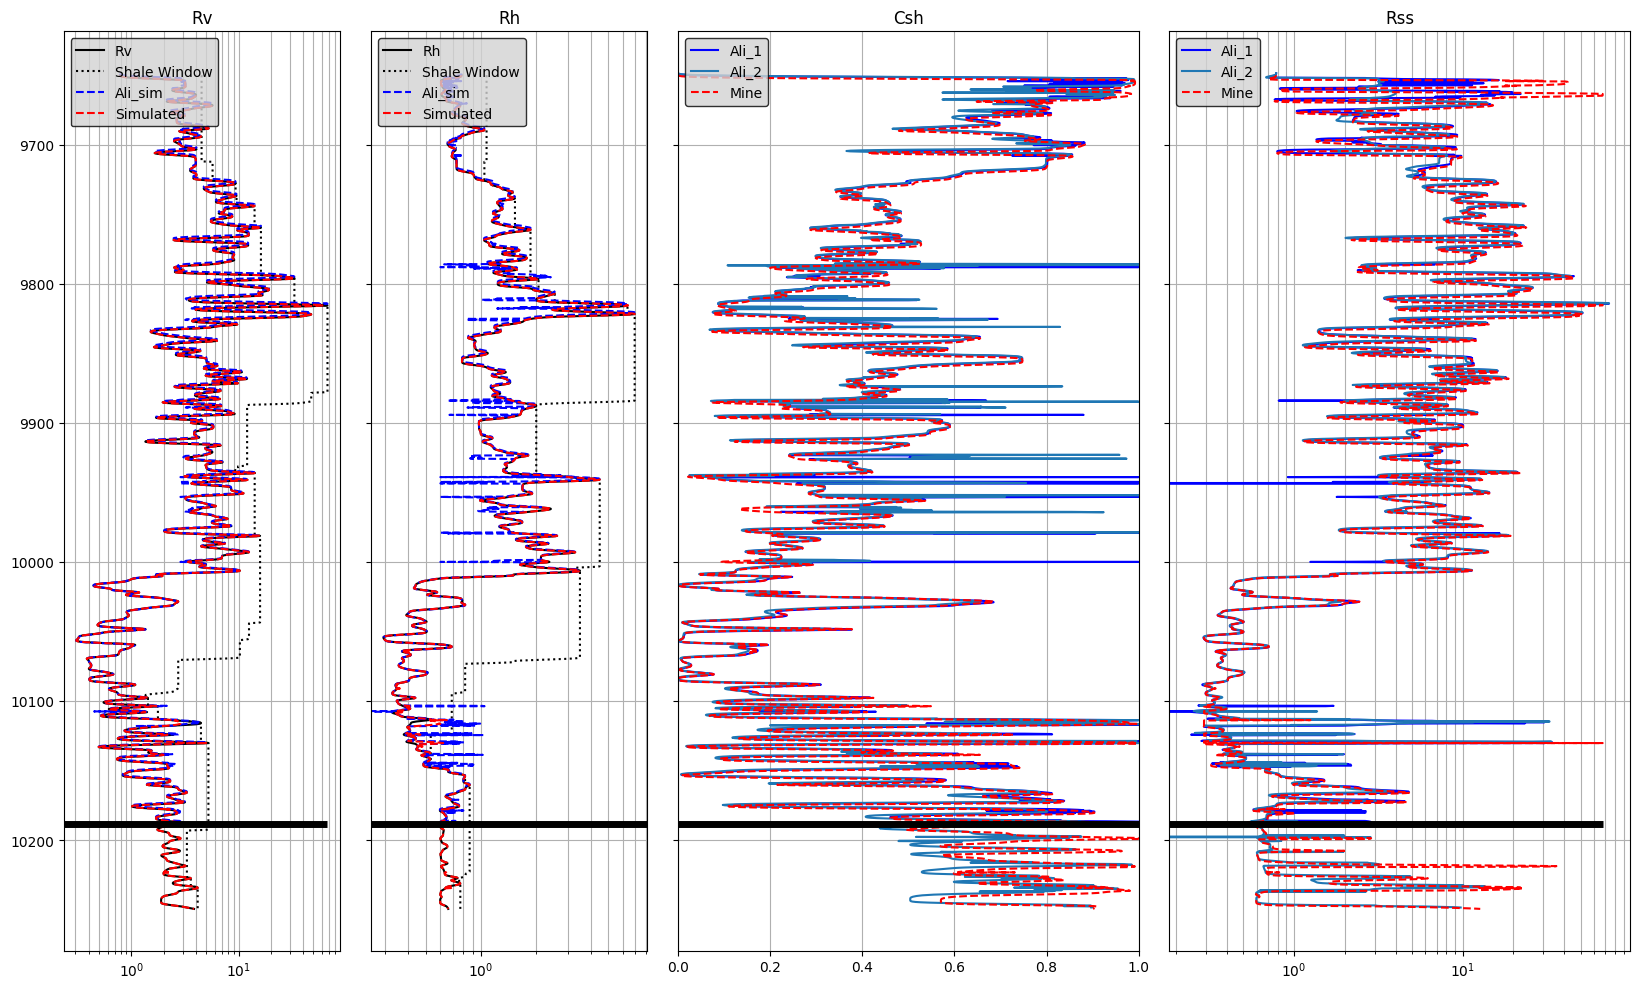

In [558]:
fig, axs = plt.subplots(1,4, figsize=(16.5,10), sharey=True, width_ratios=[0.6,0.6,1,1])
ax1, ax2, ax3, ax4 = axs

ax1.plot(case1['Rv'], case1.index, c='k', label='Rv')
ax1.plot(case1['Rvsh_win'], case1.index, c='k', ls=':', lw=1.5, label='Shale Window')
ax1.plot(Rv_sim_ali, ali.iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
ax1.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Simulated')
ax1.set(xscale='log', title='Rv')
ax1.grid(True, which='both')
ax1.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax1.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax2.plot(case1['Rh'], case1.index, c='k', label='Rh')
ax2.plot(case1['Rhsh_win'], case1.index, c='k', ls=':', lw=1.5, label='Shale Window')
ax2.plot(Rh_sim_ali, ali.iloc[1:2156,0], c='b', ls='--', label='Ali_sim')
ax2.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Simulated')
ax2.set(xscale='log', title='Rh')
ax2.grid(True, which='both')
ax2.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax2.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax3.plot(ali_Csh, ali.iloc[1:2156,0], label='Ali_1', c='b')
ax3.plot(ali.iloc[:,14], ali.iloc[:,0], label='Ali_2')
ax3.plot(sol['Csh_pred'], sol.index, label='Mine', ls='--', c='r')
ax3.set(title='Csh', xlim=(0,1))
ax3.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax3.grid(True, which='both')
ax3.hlines(10188.75, 0, 1, color='k', lw=5)

ax4.plot(ali_Rss, ali.iloc[1:2156,0], label='Ali_1', c='b')
ax4.plot(ali.iloc[:,15], ali.iloc[:,0], label='Ali_2')
ax4.plot(sol['Rss_pred'], sol.index, label='Mine', ls='--', c='r')
ax4.set(xscale='log', title='Rss'); 
ax4.legend(loc='upper left', facecolor='lightgrey', edgecolor='k')
ax4.grid(True, which='both')
ax4.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=5)

ax1.invert_yaxis()
plt.tight_layout()
plt.show()

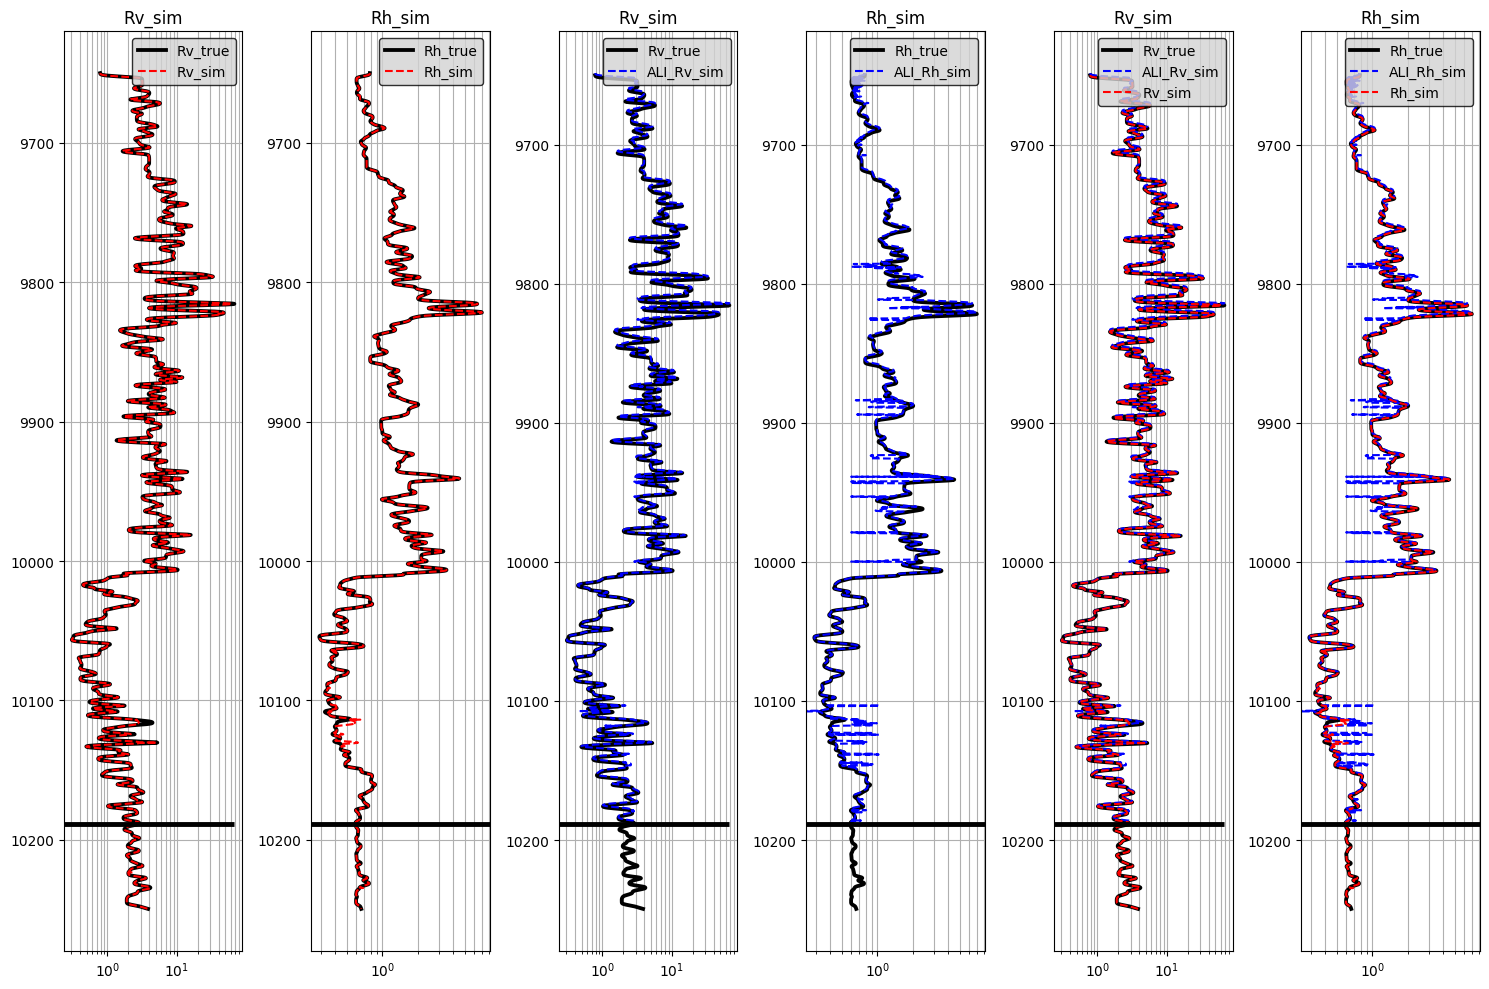

In [526]:
fig, axs = plt.subplots(1, 6, figsize=(15,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axs

ax1.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax1.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
ax1.set(title='Rv_sim'); ax1.grid(True, which='both'); ax1.set_xscale('log')
ax1.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax2.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax2.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
ax2.set(title='Rh_sim'); ax2.grid(True, which='both'); ax2.set_xscale('log')
ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax3.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax3.plot(Rv_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
ax3.set(title='Rv_sim'); ax3.grid(True, which='both'); ax3.set_xscale('log')
ax3.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax4.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax4.plot(Rh_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
ax4.set(title='Rh_sim'); ax4.grid(True, which='both'); ax4.set_xscale('log')
ax4.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax5.plot(sol['Rv'], sol.index, c='k', lw=2.75, label='Rv_true')
ax5.plot(Rv_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rv_sim')
ax5.plot(sol['Rv_sim'], sol.index, c='r', ls='--', label='Rv_sim')
ax5.set(title='Rv_sim'); ax5.grid(True, which='both'); ax5.set_xscale('log')
ax5.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

ax6.plot(sol['Rh'], sol.index, c='k', lw=2.75, label='Rh_true')
ax6.plot(Rh_sim_ali, ali.iloc[:2155,0], c='b', ls='--', label='ALI_Rh_sim')
ax6.plot(sol['Rh_sim'], sol.index, c='r', ls='--', label='Rh_sim')
ax6.set(title='Rh_sim'); ax6.grid(True, which='both'); ax6.set_xscale('log')
ax6.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')

for ax in axs:
    ax.hlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)
    ax.invert_yaxis()
    
plt.tight_layout()
plt.show()

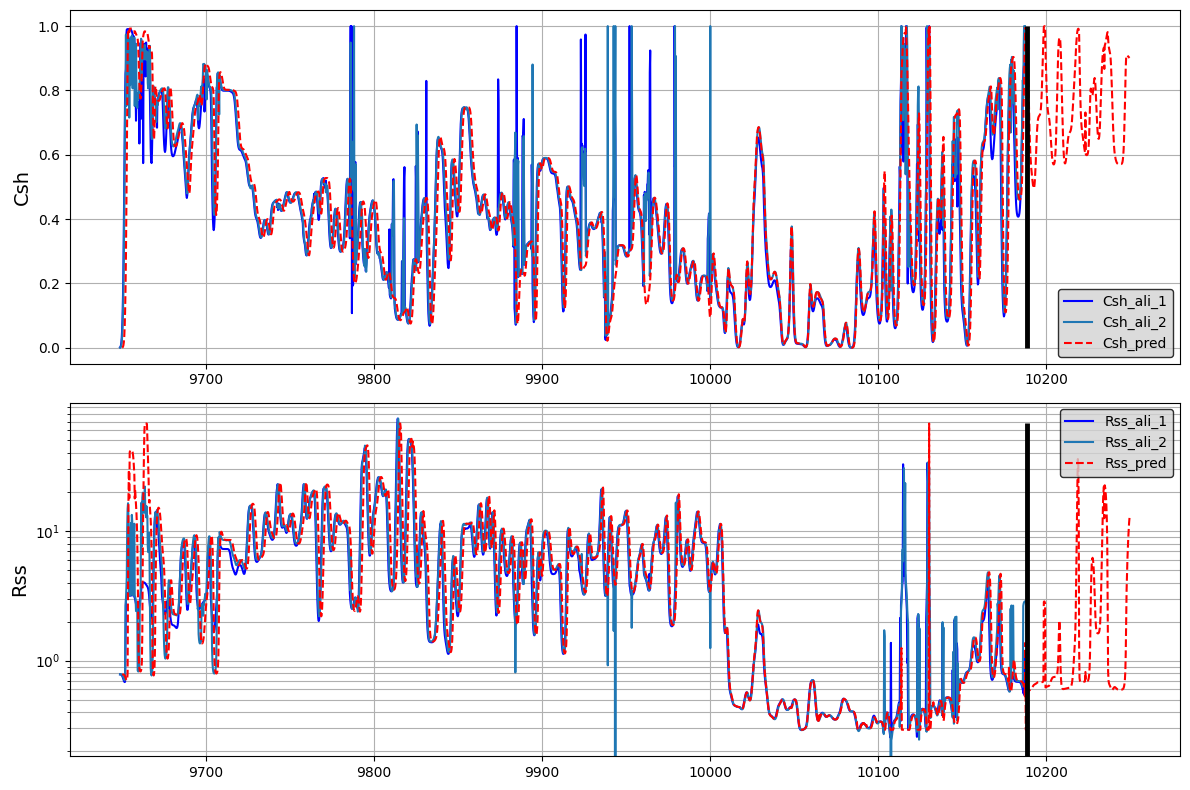

In [553]:
fig, axs = plt.subplots(2, 1, figsize=(12,8))
ax1, ax2 = axs

gri = (case1['GR'] - case1['GR'].min())/(case1['GR'].max() - case1['GR'].min())

#ax1.plot(case1.index, gri, c='gray', label='GR_Index')
ax1.plot(ali.iloc[1:2156,0], ali.iloc[1:2156,14], c='b', label='Csh_ali_1')
ax1.plot(ali.iloc[1:2156,0], ali_Csh, c='tab:blue', label='Csh_ali_2')
ax1.plot(sol.index, sol['Csh_pred'], c='r', ls='--', label='Csh_pred')
ax1.set_ylabel('Csh', fontsize=14)
ax1.grid(True, which='both')
ax1.legend(facecolor='lightgrey', edgecolor='k')
ax1.vlines(10188.75, 0, 1, color='k', lw=3.5)

ax2.plot(ali.iloc[1:2156,0], ali.iloc[1:2156,15], c='b', label='Rss_ali_1')
ax2.plot(ali.iloc[1:2156,0], ali_Rss, c='tab:blue', label='Rss_ali_2')
ax2.plot(sol.index, sol['Rss_pred'], c='r', ls='--', label='Rss_pred')
ax2.set_ylabel('Rss', fontsize=14)
ax2.grid(True, which='both')
ax2.legend(facecolor='lightgrey', edgecolor='k', loc='upper right')
ax2.set_yscale('log')
ax2.vlines(10188.75, 0, sol['Rss_pred'].max(), color='k', lw=3.5)

plt.tight_layout()
plt.show()

In [565]:
df = lasio.read('well1.las').df()
df.columns

Index(['AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'CALI', 'CORE_FLAG', 'COREPERM',
       'COREPOR', 'CORERHOB', 'CORERHOB_2SMT', 'CORERHOB_3SMT', 'CORERHOG',
       'CORESO', 'CORESW', 'DEPTH:2', 'DEPTH_ORIG', 'DPAA_TOH_72H_1D',
       'DPAP_72H_1D', 'DRHO', 'EHGR', 'FPRESS', 'FTEMP', 'GR', 'GR_CORE',
       'GR_SM', 'HAZI', 'HCGR', 'HSGR', 'HTHO', 'HURA', 'MSFT_72H_ALL_R',
       'MSFT_72H_ALL_X', 'PE', 'PHID_SS', 'POTA', 'RH72H_1D', 'RH72H_1D_FLT',
       'RHO8', 'RHOZ', 'RV72H_1D', 'RV72H_1D_FLT', 'SDEV', 'TENS', 'TNPH'],
      dtype='object')

In [680]:
d = ali.iloc[1:2156, 0].values
c = ali.iloc[1:2156, 14].values
r = ali.iloc[1:2156, 15].values
ali_sol = pd.DataFrame({'Csh_ALI':c, 'Rss_ALI':r}, index=d)
ali_sol['Rv_sim_ALI'] = c*Rvsh + (1-c)*r
ali_sol['Rh_sim_ALI'] = 1/(c/Rhsh + (1-c)/r)

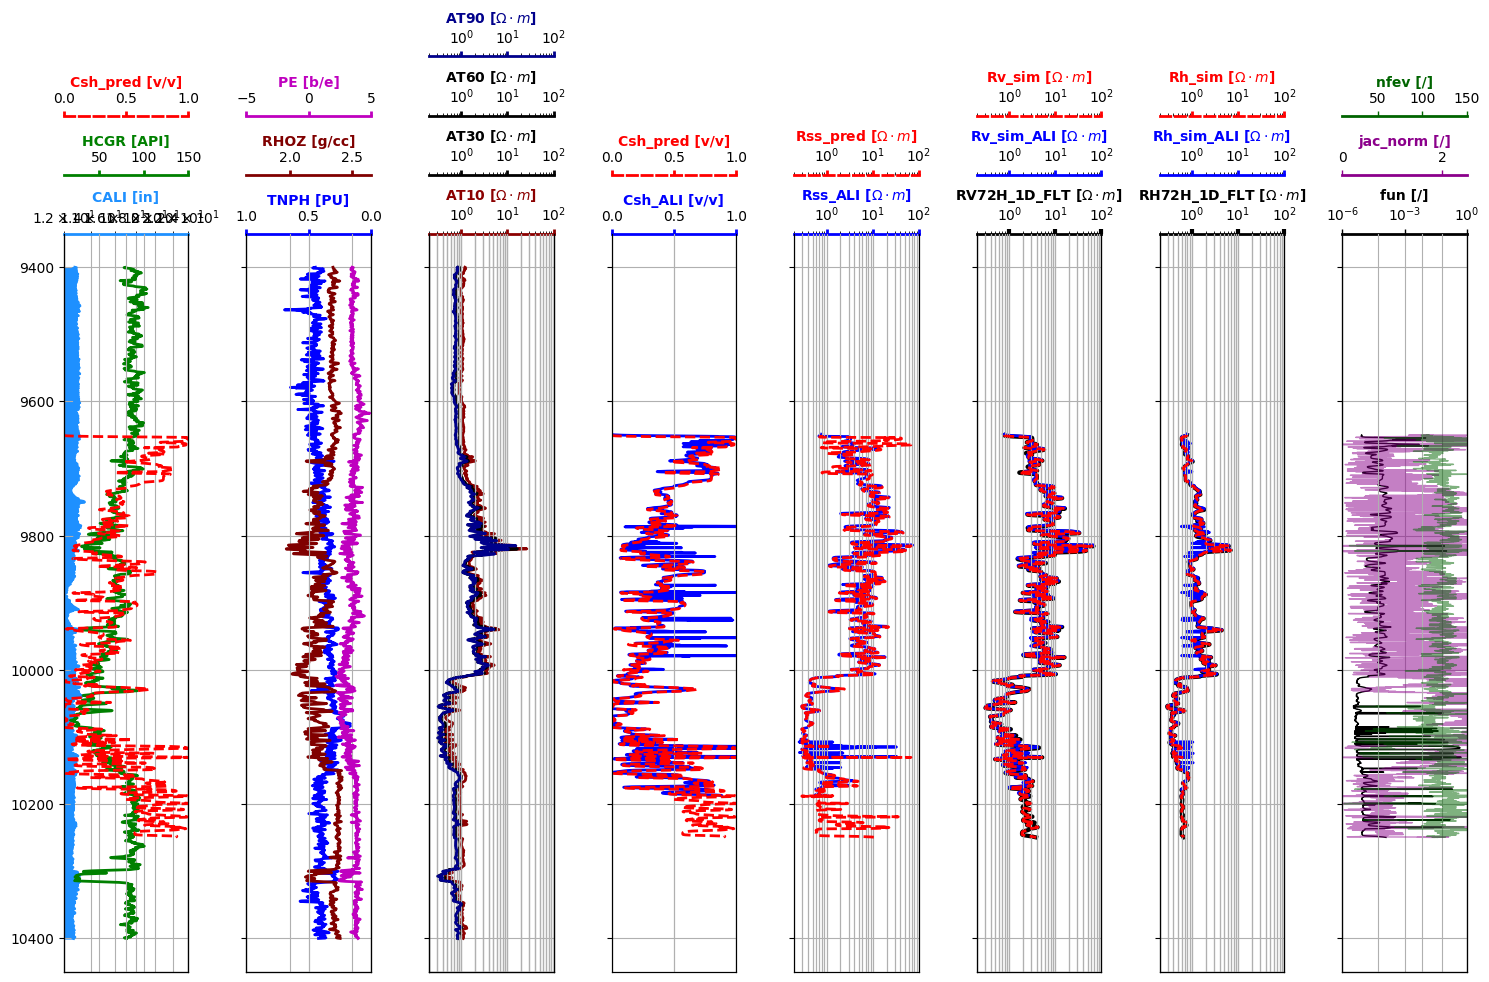

In [689]:
fig, axs = plt.subplots(1, 8, figsize=(15,10), sharey=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs

ax11, ax12 = ax1.twiny(), ax1.twiny()
ari.plot_curve(ax1, df, 'CALI', 12, 24, 'dodgerblue', units='in', fill=True, semilog=True, pad=0)
ari.plot_curve(ax11, df, 'HCGR', 10, 150, 'g', units='API', pad=8)
ari.plot_curve(ax12, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=16)

ax21, ax22 = ax2.twiny(), ax2.twiny()
ari.plot_curve(ax2, df, 'TNPH', 1, 0, 'b', units='PU', pad=0)
ari.plot_curve(ax21, df, 'RHOZ', 1.65, 2.65, 'maroon', units='g/cc', pad=8)
ari.plot_curve(ax22, df, 'PE', -5, 5, 'm', units='b/e', pad=16)

ax31, ax32, ax33 = ax3.twiny(), ax3.twiny(), ax3.twiny()
ari.plot_curve(ax3, df, 'AT10', 0.2, 100, 'darkred', semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax31, df, 'AT30', 0.2, 100, 'k', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax32, df, 'AT60', 0.2, 100, 'k', semilog=True, units='$\Omega\cdot m$', pad=16)
ari.plot_curve(ax33, df, 'AT90', 0.2, 100, 'darkblue', semilog=True, units='$\Omega\cdot m$', pad=24)

ax41 = ax4.twiny()
ari.plot_curve(ax4, ali_sol, 'Csh_ALI', 0, 1, 'b', units='v/v', pad=0)
ari.plot_curve(ax41, sol, 'Csh_pred', 0, 1, 'r', ls='--', units='v/v', pad=8)

ax51 = ax5.twiny()
ari.plot_curve(ax5, ali_sol, 'Rss_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax51, sol, 'Rss_pred', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=8)

ax61, ax62 = ax6.twiny(), ax6.twiny()
ari.plot_curve(ax6, df, 'RV72H_1D_FLT', 0.2, 100, 'k', s=3, semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax61, ali_sol, 'Rv_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax62, sol, 'Rv_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

ax71, ax72 = ax7.twiny(), ax7.twiny()
ari.plot_curve(ax7, df, 'RH72H_1D_FLT', 0.2, 100, 'k', s=3, semilog=True, units='$\Omega\cdot m$', pad=0)
ari.plot_curve(ax71, ali_sol, 'Rh_sim_ALI', 0.2, 100, 'b', semilog=True, units='$\Omega\cdot m$', pad=8)
ari.plot_curve(ax72, sol, 'Rh_sim', 0.2, 100, 'r', ls='--', semilog=True, units='$\Omega\cdot m$', pad=16)

ax81, ax82 = ax8.twiny(), ax8.twiny()
ari.plot_curve(ax8, sol, 'fun', 1e-6, 1e0, 'k', s=1, semilog=True, units='/', pad=0)
ari.plot_curve(ax81, sol, 'jac_norm', 0, 2.5, 'darkmagenta', s=1, units='/', pad=8, alpha=0.5)
ari.plot_curve(ax82, sol, 'nfev', 10, 150, 'darkgreen', s=1, units='/', pad=16, alpha=0.5)

ax1.invert_yaxis()
plt.tight_layout()
plt.show()